In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pylab 
import scipy.stats as stats

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest

In [25]:
def print_estimate_errors(pvals_aa: np.array, pvals_ab: np.array, alpha: float) -> None:
    estimate_first_type_error = np.mean(pvals_aa < alpha)
    estimate_secont_type_error = np.mean(pvals_ab < alpha)
    aa_interval = binomial_ci(estimate_first_type_error, len(pvals_aa))
    ab_interval = binomial_ci(estimate_secont_type_error, len(pvals_ab))
    print(f'(AA) Вероятность ошибки первого рода = {estimate_first_type_error}, доверительный интервал {aa_interval}')
    print(f'(AB) Мощность (power) теста = {estimate_secont_type_error}, доверительный интервал {ab_interval}')


def binomial_ci(estimator: float, n: int) -> list:
    norm_ppf = stats.norm.ppf(0.95)
    interval = round(norm_ppf * np.sqrt(estimator * (1 - estimator) / n), 3)
    return [estimator - interval, estimator + interval]


def plot_pvals(pvals_aa: np.array, pvals_ab: np.array, alpha: float,
               n_iters: int = 1000) -> None:
    X = np.linspace(0, 1, n_iters)
    Y_aa = [np.mean(pvals_aa < x) for x in X]
    Y_ab = [np.mean(pvals_ab < x) for x in X]

    plt.plot(X, Y_aa, label='AA')
    plt.plot(X, Y_ab, label='AB')

    estimated_first_type_error = np.mean(pvals_aa < alpha)
    estimated_second_type_error = np.mean(pvals_ab >= alpha)

    y_one = estimated_first_type_error
    y_two = 1 - estimated_second_type_error

    plt.plot(X, X, '--k')
    plt.plot([alpha, alpha], [0, 1], '--k', alpha=0.7)
    plt.plot([0, alpha], [y_one, y_one], '--k', alpha=0.7)
    plt.plot([0, alpha], [y_two, y_two], '--k', alpha=0.7)

    plt.legend()
    plt.show()


def estimate_sample_size(effect, std, alpha, beta) -> int:
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / effect ** 2)
    return sample_size

In [48]:
def calculate_pval(a: np.array, b: np.array, test: str) -> float:
    if test == 'ttest_ind':
        _, pval = stats.ttest_ind(a, b)
    elif test == 'mannwhitneyu':
        _, pval = stats.mannwhitneyu(a, b)
    elif test == 'ztest':
        _, pval = ztest(a, b)
    else:
        print('calculate_pval, Название теста не найдено')
        pval = 0.0
    return pval


def run_synthetic_experiments(values: pd.DataFrame, sample_size: int, effect: int=0, n_iters: int=1000, 
                              test: str='ttest_ind', std: str='identical', values2: pd.DataFrame=None) -> list:
    pvals = []
    for _ in range(n_iters):
        if std == 'identical':
            a, b = np.random.choice(values, size=(2, sample_size))
        elif std == 'diff':
            a = np.random.choice(values, size=sample_size)
            b = np.random.choice(values2, size=sample_size)
        else:
            print('run_synthetic_experiments, Неизвестное значение для std')
        b += effect
        pval = calculate_pval(a, b, test)
        pvals.append(pval)
    return np.array(pvals)

# ttest_ind

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.07, доверительный интервал [0.028000000000000004, 0.11200000000000002]
(AB) Мощность (power) теста = 0.79, доверительный интервал [0.7230000000000001, 0.857]


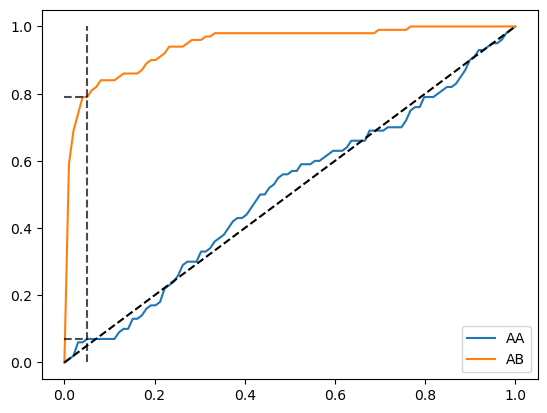

In [47]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
effect = 100
mu_pilot = mu_control + effect
std = 800
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std = 8
# values = np.random.lognormal(mu_control, std, size) # выборка с lognormal распределения
# values = np.log(values)

# k, o = 10, 2
# mu_control = k * o
# effect = 2
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, test='ttest_ind')
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, test='ttest_ind')

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# mannwhitneyu

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.03, доверительный интервал [0.0019999999999999983, 0.057999999999999996]
(AB) Мощность (power) теста = 0.82, доверительный интервал [0.7569999999999999, 0.883]


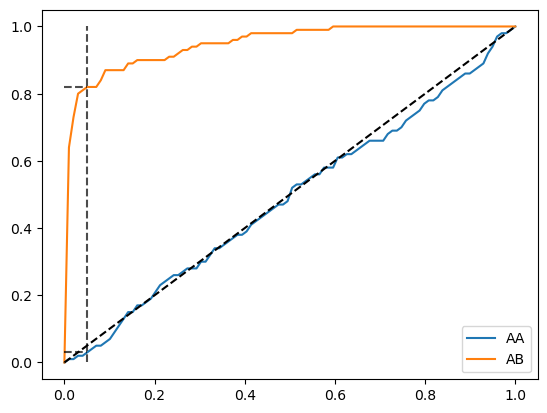

In [46]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
effect = 100
mu_pilot = mu_control + effect
std = 800
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std = 8
# values = np.random.lognormal(mu_control, std, size) # выборка с логнормального распределения
# values = np.log(values)

# k, o = 10, 5
# mu_control = k * o
# effect = 1
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, test='mannwhitneyu')
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, test='mannwhitneyu')

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# ztest

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.08, доверительный интервал [0.035, 0.125]
(AB) Мощность (power) теста = 0.82, доверительный интервал [0.7569999999999999, 0.883]


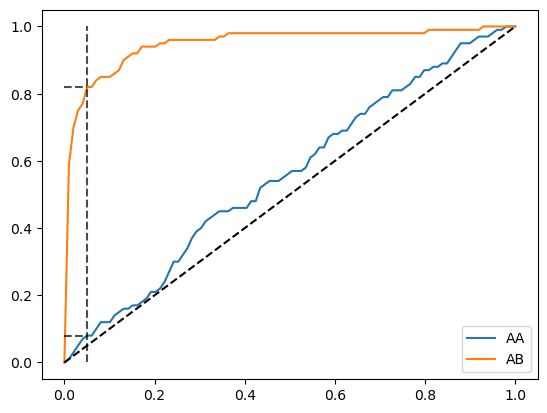

In [45]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
effect = 100
mu_pilot = mu_control + effect
std = 800
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std = 8
# values = np.random.lognormal(mu_control, std, size) # выборка с логнормального распределения
# values = np.log(values)

# k, o = 10, 3
# mu_control = k * o
# effect = 1
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, test='ztest')
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, test='ztest')

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# proportions_ztest

In [31]:
def estimate_sample_size_proportions(p, effect, alpha, beta):
    z_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    z_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = (p * (1 - p) + (p + effect) * (1 - (p + effect)))
    sample_size = int((z_alpha + z_beta) ** 2 * var / effect ** 2) 
    return sample_size


def run_synthetic_experiments_proportions(values: pd.DataFrame, sample_size: int,
                                        effect: int=0, n_iters: int=1000) -> list:
    pvals = []
    for _ in range(n_iters):
        mean = values.mean()
        a = np.random.binomial(1, mean, sample_size)
        b = np.random.binomial(1, mean+effect, sample_size)
        
        a_count, b_count = a.sum(), b.sum()
        a_nobs, b_nobs = a.size, b.size
        
        _, pval = proportions_ztest([a_count, b_count], [a_nobs, b_nobs])
        pvals.append(pval)
    return np.array(pvals)

Необходимый размер групп = 2209
(AA) Вероятность ошибки первого рода = 0.03, доверительный интервал [0.0019999999999999983, 0.057999999999999996]
(AB) Мощность (power) теста = 0.78, доверительный интервал [0.712, 0.8480000000000001]


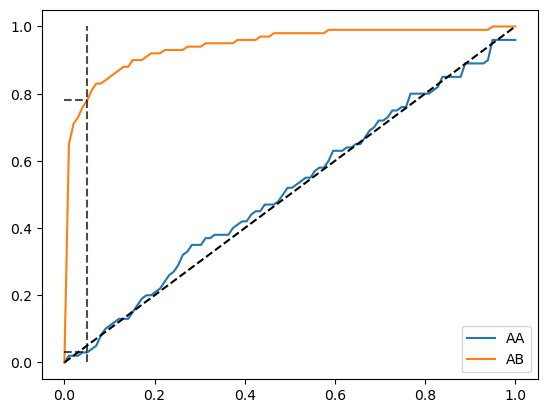

In [44]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 0.05
effect = 0.02
mu_pilot = mu_control + effect

values = np.random.binomial(1, mu_control, size)

sample_size = estimate_sample_size_proportions(mu_control, effect, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments_proportions(values, sample_size, effect=0, n_iters=n_iters)
pvals_ab = run_synthetic_experiments_proportions(values, sample_size, effect=effect, n_iters=n_iters)

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# ttest_ind different variance

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.04, доверительный интервал [0.008, 0.07200000000000001]
(AB) Мощность (power) теста = 0.82, доверительный интервал [0.7569999999999999, 0.883]


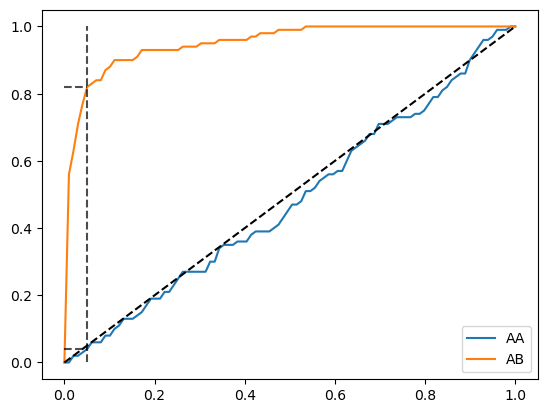

In [41]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
std, std2 = 800, 900
effect = 100
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения
values2 = np.random.normal(mu_control, std2, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std, std2 = 8, 10
# values = np.random.lognormal(mu_control, std, size) # выборка с lognormal распределения
# values2 = np.random.lognormal(mu_control, std2, size) # выборка с lognormal распределения
# values = np.log(values)
# values2 = np.log(values2)

# k = 10
# o, o2 = 1, 2
# mu_control = k * o
# effect = 1
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения
# values2 = np.random.gamma(k, o2, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения
# values2 = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, std='diff', values2=values2)
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, std='diff', values2=values2)

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# mannwhitneyu different variance

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.05, доверительный интервал [0.014000000000000005, 0.086]
(AB) Мощность (power) теста = 0.76, доверительный интервал [0.69, 0.8300000000000001]


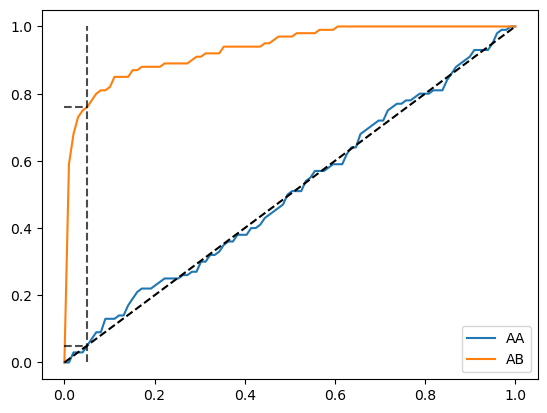

In [42]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
std, std2 = 800, 900
effect = 100
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения
values2 = np.random.normal(mu_control, std2, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std, std2 = 8, 10
# values = np.random.lognormal(mu_control, std, size) # выборка с логнормального распределения
# values2 = np.random.lognormal(mu_control, std2, size) # выборка с логнормального распределения
# values = np.log(values)
# values2 = np.log(values2)

# k = 10
# o, o2 = 1, 2
# mu_control = k * o
# effect = 1
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения
# values2 = np.random.gamma(k, o2, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, std='diff', values2=values2)
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, std='diff', values2=values2)

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)

# ztest different variance

Необходимый размер групп = 1004
(AA) Вероятность ошибки первого рода = 0.05, доверительный интервал [0.014000000000000005, 0.086]
(AB) Мощность (power) теста = 0.62, доверительный интервал [0.54, 0.7]


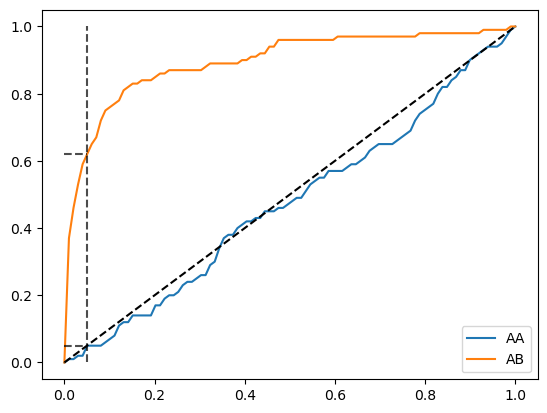

In [43]:
alpha = 0.05
beta = 0.2

size = 10000

mu_control = 2500
std, std2 = 800, 900
effect = 100
values = np.random.normal(mu_control, std, size) # выборка с нормального распределения
values2 = np.random.normal(mu_control, std2, size) # выборка с нормального распределения

# mu_control = 30
# effect = 1
# std, std2 = 8, 10
# values = np.random.lognormal(mu_control, std, size) # выборка с логнормального распределения
# values2 = np.random.lognormal(mu_control, std2, size) # выборка с логнормального распределения
# values = np.log(values)
# values2 = np.log(values2)

# k = 10
# o, o2 = 1, 2
# mu_control = k * o
# effect = 1
# std = np.sqrt(k * o**2)
# values = np.random.gamma(k, o, size) # выборка с gamma распределения
# values2 = np.random.gamma(k, o2, size) # выборка с gamma распределения

# mu_control = 10
# effect = 1
# std = np.sqrt(mu_control)
# values = np.random.poisson(mu_control, size) # выборка с poisson распределения


sample_size = estimate_sample_size(effect, std, alpha, beta)
print(f'Необходимый размер групп = {sample_size}')

n_iters = 100
pvals_aa = run_synthetic_experiments(values, sample_size, effect=0, n_iters=n_iters, std='diff', values2=values2)
pvals_ab = run_synthetic_experiments(values, sample_size, effect=effect, n_iters=n_iters, std='diff', values2=values2)

print_estimate_errors(pvals_aa, pvals_ab, alpha)
plot_pvals(pvals_aa, pvals_ab, alpha, n_iters)